# AoAI - Assignment 2 - Car Reviews Classification

In [1]:
# Install packages as required
# !pip install spacy
# !pip install seaborn
# !pip install scikit-learn
# !pip install pandas
# !pip install numpy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
!python -m spacy download en_core_web_sm

# Part One

In [3]:
# Import dataset
df = pd.read_csv('car-reviews.csv')

# Shuffle with seed (random_state) and reset index
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

A brief inspection of the dataframe below reveals there are 1,382 reviews in total, with 2 classes each having 691 rows each. None of the reviews are duplicates as can be seen by the entire 1,382 rows being unique

In [4]:
df.describe()

,Sentiment,Review
count,1382,1382
unique,2,1382
top,Pos,Okay I have to admit this is my first Ford U...
freq,691,1


In [5]:
print(f"The average length of the Positive reviews is {round(df[df['Sentiment']=='Pos']['Review'].str.len().mean())} characters.")
print(f"The average length of the Negative reviews is {round(df[df['Sentiment']=='Neg']['Review'].str.len().mean())} characters.")

The average length of the Positive reviews is 2201 characters.
The average length of the Negative reviews is 2448 characters.



### ASSESSMENT CRITERIA 1.1 - exclusion of stop words, punctuation, and case-insensitive handling
    

In [6]:
class Preprocess:
    """
        For each review in the dataset, this class:
        1. Removes punctuation and stop words from each review
        2. Removes any non-alphabetical tokens
        3. Lemmatises the token and converts to lower case
        4. Removes lemmas < 2 characters in length
        """
   
    def main(self, review):
        """
        The main function for the preprocessing pipeline, which calls the other preprocessing functions
        on each token in the given review.
        
        The lemmatisation step is only applied if the token is not a stop word, is not punctuation,
        and is above 2 characters in length
        
        param review : the original review string
        returns preprocessed_review: a cleaned string of lemmas
        """
        
        preprocessed_review_tokens = [self.lemmatise_lower_token(token) for token in review
                                          if self.is_not_stop_word(token) 
                                          and self.is_not_punctuation(token)
                                          and self.is_not_short(token)
                                     ]
        
        # Join list together to re-form as a sentence
        preprocessed_review = ' '.join(preprocessed_review_tokens)

        return preprocessed_review
    
    def is_not_stop_word(self, token):
        """
        Filter out stop words as well as any blank tokens
        """
        if (not token.text.strip() or not token or token.is_stop):
            return False
        return True
    
    def is_not_short(self, token):
        """
        Trims the review for any tokens less than or equal to two characters in length
        """
        if len(token) <=2:
            return False
        return True

    def is_not_punctuation(self, token):
        """
        Filter out punctuation
        """
        if token.is_punct:
            return False
        return True

    def lemmatise_lower_token(self, token):
        """
        Reduce token to its lowercase lemma form if it is alphabetical in nature
        """

        if token.text.isalpha():
            return token.lemma_.strip().lower()
        return ''

    

In [7]:
# Initialise Spacy's Language class with the english vocabulary.
# To save processing time exclude the named entity recognition and dependency parsing modules.
nlp = spacy.load('en_core_web_sm', exclude=['ner','parser'])

In [8]:
# Apply the preprocessing class - see class docstrings for details
# Note : this takes about 45 seconds to process
df["Review_Preprocessed"] = [Preprocess().main(doc) for doc in nlp.pipe(df["Review"].tolist())]

The below cell shows a sample of the original reviews and the preprocessed reviews. It can be seen that all words have been lowercased, stopwords as well as numbers have been removed, and any punctuation that may exist or words shorter than 3 characters have been removed too.

In [53]:
df[:5]

,Sentiment,Review,Review_Preprocessed
0,Pos,Being a young single person such as myself ...,young single person need minivan check nonethe...
1,Pos,First I ll say this The 1995 and to some e...,extent windstar sucked reliability wise model...
2,Pos,I have owned my Ford Econoline full size van ...,own ford econoline size van regency custom con...
3,Pos,We bought our car brand new four years ago I...,buy car brand new year ago want car perfect co...
4,Neg,I bought my 1997 Taurus LX from Tom Wood Ford...,buy taurus tom wood ford indianapolis april ...


### ASSESSMENT CRITERIA 1.2 - demonstration of lemmatisation

Lemmatisation is demonstrated below using the function `lemmatise_lower_token()` which is also applied to the dataset in the `Preprocess` class above.

It was decided to use lemmatising due it's more advanced abilities of being able to convert a word into a meaningful base-word, as well as being able to distinguish words by their Part of Speech. This is shown in Demo 1 below where the word 'drivers' is correctly converted to 'driver' rather than being converted to 'drive'. This is because the lemma of a plural noun is the singular noun rather than the lemma of the related verb i.e. they belong to a different set of lexemes.

The words contained in the rest of the demos are all converted to the same lemma respectively.

In [10]:
# LEMMATISATION DEMO 1
demo1 = nlp('driving drove drivers')
print(f"Lemmatisation Demo 1:\n Input string : {demo1.text}\
            \n Lemmatised output :{[Preprocess().lemmatise_lower_token(token) for token in demo1]}\n\n")

# LEMMATISATION DEMO 2
demo2 = nlp('requires required requiring')
print(f"Lemmatisation Demo 2:\n Input string : {demo2.text}\
            \n Lemmatised output : {[Preprocess().lemmatise_lower_token(token) for token in demo2]}\n\n")

# LEMMATISATION DEMO 3
demo3 = nlp('spaces spaced spacing')
print(f"Lemmatisation Demo 3:\n Input string : {demo3.text}\
            \n Lemmatised output : {[Preprocess().lemmatise_lower_token(token) for token in demo3]}\n\n")

Lemmatisation Demo 1:
 Input string : driving drove drivers            
 Lemmatised output :['drive', 'drive', 'driver']


Lemmatisation Demo 2:
 Input string : requires required requiring            
 Lemmatised output : ['require', 'require', 'require']


Lemmatisation Demo 3:
 Input string : spaces spaced spacing            
 Lemmatised output : ['space', 'space', 'space']




### ASSESSMENT CRITERIA 1.5 (partial) - Split data into 80% training & 20% testing sets

In [11]:
# Split dataset into 80% training and 20% testing set, using `stratify` to ensure a balanced representation of 
# positive and negative reviews in both sets.
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['Sentiment'],random_state=1)

### ASSESSMENT CRITERIA 1.3 -  Vectorising Reviews

In [12]:
# Set seed to ensure reproducibility of results
np.random.seed(100)

# Initialise Bag of Words (CountVectorizer()) with unigrams (ngram_range) 
# and setting binary=False to output absolute lemma counts.
bow = CountVectorizer(ngram_range=(1, 1), binary=False)

In [13]:
# Fit the bag of words model using only the training dataset to prevent leakage, 
# and transform the training set to an array of vectors
X_train = bow.fit_transform(df_train['Review_Preprocessed'].values)

In [14]:
# The bag of words vectorizer contains 10,578 unique lemmas...
len(bow.vocabulary_.keys())

10578

In [15]:
# ...which is reflected in the shape of the array once it has been transformed using the fitted CountVectorizer.
X_train.toarray().shape

(1105, 10578)

The below cells show samples of the lemmatised reviews being converted to a vector of counts per appearance of each lemma. Each demo consists of a single preprocessed review in a dataframe combined with the top 10 (unigram) lemma counts (i.e. the output of the vectoriser) for that review.

##### Vector Demo 1

In [16]:
# Create sample dataframe of BoW outputs
count_vect_df = pd.DataFrame(X_train[:1].todense(), columns=bow.get_feature_names())

# Re-order counts in descending order. Keep top 10 counts for demo purposes
# Credit : https://stackoverflow.com/questions/12358360/order-columns-of-a-pandas-dataframe-according-to-the-values-in-a-row
count_vect_df= count_vect_df[count_vect_df.iloc[-1,:].sort_values(ascending=False).index[:10]]

# Combine lemmatised review with BoW counts
pd.concat([df_train['Review_Preprocessed'][:1].reset_index(drop=True), count_vect_df], axis=1)

,Review_Preprocessed,car,door,ford,unlocked,family,wonderful,taurus,nice,driver,drive
0,husband come ford family vehicle buy ford majo...,7,4,4,3,3,3,3,2,2,2


##### Vector Demo 2

In [17]:
# Process as above with demo 1
count_vect_df = pd.DataFrame(X_train[1:2].todense(), columns=bow.get_feature_names())

count_vect_df= count_vect_df[count_vect_df.iloc[-1,:].sort_values(ascending=False).index[:10]]

pd.concat([df_train['Review_Preprocessed'][1:2].reset_index(drop=True), count_vect_df], axis=1)

,Review_Preprocessed,excursion,ford,vehicle,buy,gas,kill,opinion,safe,fuel,big
0,segment add later appear ford finally come ter...,7,6,6,5,5,5,4,4,4,4


##### Vector Demo 3

In [18]:
# Process as above with demo 1
count_vect_df = pd.DataFrame(X_train[2:3].todense(), columns=bow.get_feature_names())

count_vect_df= count_vect_df[count_vect_df.iloc[-1,:].sort_values(ascending=False).index[:10]]

pd.concat([df_train['Review_Preprocessed'][2:3].reset_index(drop=True), count_vect_df], axis=1)

,Review_Preprocessed,door,car,big,small,drive,size,sport,utility,happy,time
0,alright interested buy sport utility vehicle t...,5,4,3,3,3,3,2,2,2,2


### ASSESSMENT CRITERIA 1.4 - Appropriate Naïve Bayes model

For this classification task, the Multinomial Naïve Bayes model is appropriate, as it is able to capture information pertaining to the frequency of words in the reviews [1], which is relevant because of the non-binary format of the vectorised data.

In [19]:
# Instantiate Multinomial Naïve Bayes model from scikit-learn
bow_mnb = MultinomialNB()

### ASSESSMENT CRITERIA 1.5 (continued)
- Use of 80% of data to train model
- Remaining 20% used as test data
- Up until this point, test data has not been used for anything

In [20]:
# Fit model using the BoW vectors and labels of only the training set
bow_mnb.fit(X_train, df_train['Sentiment'].values)

MultinomialNB()

### Proof that model can cope with words in test set that are not in the training set

The below cells are an investigation into how the model handles words that it has not seen before when making predictions.



In [21]:
# First create a list of all unique words/lemmas in the training set
words_in_train_set = list(bow.vocabulary_.keys())

In [22]:
# Instantiate Counter to track words that are in the test set but not in the training set
words_unique_to_testset = Counter()

# For each row in the test set
for row in df_test['Review_Preprocessed'].str.lower().str.split():
    # For each word in that row
    for word in row:
        # If that word is not in the training set
        if word not in words_in_train_set:
            # Add to Counter
            words_unique_to_testset[word]+=1
            
words_unique_to_testset = list(words_unique_to_testset.keys())

In [23]:
# Convert the first ten words into a single string and convert to vector
missing_words_vect = bow.transform([' '.join(words_unique_to_testset[:10])])

print(f"Random sentence containing words only in test set:\n\n '{' '.join(words_unique_to_testset[:10])}'")

Random sentence containing words only in test set:

 'denominator wells nee eddied sealing ducting damaged saftety premise poverty'


In [24]:
# Investigate vector

# Convert to pandas dataframe
count_vect_df = pd.DataFrame(missing_words_vect.todense(), columns=bow.get_feature_names())

# Re-order counts in descending order. Keep top 10 counts for demo purposes
count_vect_df= count_vect_df[count_vect_df.iloc[-1,:].sort_values(ascending=False).index[:10]]

The below cell prints the output of the vectorised (in descending order) string containing words only in the test set. 

In [25]:
count_vect_df

,aaa,preschool,presence,present,presently,preservation,preserve,preset,president,press
0,0,0,0,0,0,0,0,0,0,0



<b>This shows that missing words are handled at the vectorising stage, whereby the vector is just an array of all zeros. This means that any word that hasn't been seen before gets a count of 0.</b>

To further verify, the below cells run the string (containing all unseen words) through the classifier.

In [26]:
# Running that string through the classifier outputs 'Neg'
bow_mnb.predict(missing_words_vect)

array(['Neg'], dtype='<U3')

In [27]:
# However we can see that the probabilities of the two classes are almost identical. 
# This shows that words that the model has never seen before bare minimal impact on the classification.
bow_mnb.predict_proba(missing_words_vect)

array([[0.50045249, 0.49954751]])

In [28]:
# Adding a positive word that IS in the training set changes the prediction to 'Pos'
missing_words_vect_adj = bow.transform([' '.join(words_unique_to_testset[:10])+ ' great'] )

In [29]:
bow_mnb.predict(missing_words_vect_adj)

array(['Pos'], dtype='<U3')

In [30]:
# The impact of adding a single positive word on the resulting probability vector is shown below,
# now with a 67% probability of being 'Pos'
bow_mnb.predict_proba(missing_words_vect_adj)

array([[0.33163719, 0.66836281]])

### ASSESSMENT CRITERIA 1.6 - Output of Bag Of Words Model Confusion Matrix

The below cells run the test datase through the Bag of Words vectoriser and then the fitted Multinomial Naïve Bayes model to obtain predictions on unseen data.

#### Predictions

In [31]:
# Using the already-fitted BoW model, transform the test set into BoW vectors
bow_test_vect = bow.transform(df_test['Review_Preprocessed'].values)

In [32]:
# Test model using the test data set
bow_prediction = bow_mnb.predict(bow_test_vect)

In [33]:
# Combine predictions with original test dataset
results_df = pd.merge(left=df_test[['Review','Sentiment']].reset_index(drop=True),\
                      right=pd.DataFrame(bow_prediction, columns=['Prediction']), left_index=True, \
                      right_index=True)

In [34]:
# Output sample of predictions
results_df[:5]

,Review,Sentiment,Prediction
0,ive driven Fords since I got my Mustang when ...,Pos,Pos
1,My wife loves the Explorer but she is 5 5 t...,Neg,Pos
2,We 146ve had our 98 Windstar since it was new...,Pos,Neg
3,im a Toyota person but I came very close to ...,Pos,Neg
4,I have a 1991 Ford Escort LX im 16 years old...,Pos,Pos


#### Confusion Matrix

In [35]:
# Create confusion matrix using the predictions and true labels of the test set
bow_cm = confusion_matrix(y_true=df_test['Sentiment'], y_pred=bow_prediction, labels=['Pos','Neg'])

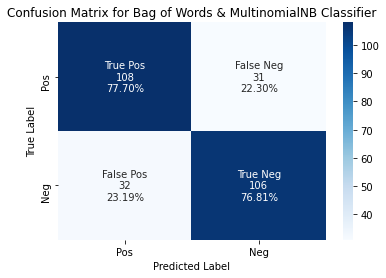

In [36]:
# Configure group names, counts and percentage metrics
bow_group_names = ['True Pos','False Neg','False Pos','True Neg']

bow_group_counts = ["{0:0.0f}".format(value) for value in
                bow_cm.flatten()]

bow_group_percentages = ["{0:.2%}".format(value/np.sum(row)) for row in bow_cm for value in row]


# Configure labels for each segment
bow_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(bow_group_names,bow_group_counts,bow_group_percentages)]

bow_labels = np.asarray(bow_labels).reshape(2,2)

cms = sns.heatmap(bow_cm, annot=bow_labels, fmt='', cmap='Blues', xticklabels=['Pos','Neg'], yticklabels=['Pos','Neg'])

plt.xlabel("Predicted Label") 

plt.ylabel("True Label") 

plt.title("Confusion Matrix for Bag of Words & MultinomialNB Classifier")

plt.show()
# Credit : https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

In [37]:
# Calculate counts of TP/TN/FP/FN to verify against confusion matrix
print(f"Number of True Positives : {results_df[(results_df['Sentiment']=='Pos') & (results_df['Prediction']=='Pos')].shape[0]} - the correct 'Pos' predictions\n")
print(f"Number of False Positives : {results_df[(results_df['Sentiment']=='Neg') & (results_df['Prediction']=='Pos')].shape[0]} - the incorrect 'Pos' predictions (true label is 'Neg')\n")
print(f"Number of True Negatives : {results_df[(results_df['Sentiment']=='Neg') & (results_df['Prediction']=='Neg')].shape[0]} - the correct 'Neg' predictions \n")
print(f"Number of False Negatives : {results_df[(results_df['Sentiment']=='Pos') & (results_df['Prediction']=='Neg')].shape[0]} - the incorrect 'Neg' predictions (true label is 'Pos') \n")

Number of True Positives : 108 - the correct 'Pos' predictions

Number of False Positives : 32 - the incorrect 'Pos' predictions (true label is 'Neg')

Number of True Negatives : 106 - the correct 'Neg' predictions 

Number of False Negatives : 31 - the incorrect 'Neg' predictions (true label is 'Pos') 



The confusion matrix for the classifier shows how the predictions on the test set of the model compare to the true labels. The number in each segment shows how many rows with the relevant true label received the relevant prediction, and the percentage represents the proportion of the true labels, with horizontally adjacent cells adding up to 100%.

The confusion matrix shows an approximately even balance of the models ability to predict both positive and negative classes, with the former being slightly better at 77.7% compared to the latter 76.8% in the true positive and true negative rates, respectively.

# Part Two: Term Frequency - Inverse Document Frequency

### ASSESSMENT CRITERIA 2.1

Another approach to obtaining vectorisations is the Term Frequency - Inverse Document Frequency (TF-IDF) method. It offers an opportunity to train a model with data that contains more granular information about each particular words relevance to it's containing document.

TF-IDF consists of two components:
- <b>The Term Frequency</b> - a measure of the occurrence / frequency of a term in a given document and (it's simplest form) is given by:

   TF(t,d) = $ \frac{t}{d} $
   
   Where `t` is the count of a particular term in a document and `d` is the total term count in the document
     
     

- <b>The Inverse Document Frequency</b> - a measure of how rare that word is in the rest of the corpus, with values closer to 0 equating to being more common. The most basic version is given by:

     IDF(t) = $  \frac {N}{df}$ 
     
   Where `N` is the number of documents in the corpus and `df` is the count of occurrences of term t in the entire corpus
     
These two are multiplied to give the TF-IDF:

    TF.IDF = TF(t,d) . IDF(t)

<b> Additional Remarks </b>


In the cell below the parameter `sublinear_tf` is being applied, which addresses the notion that 20 occurrences of a particular term in a single document does not necessarily equate to 20 times more importance than a word that appears once. It is a modification of the TF component. [2]

Normalisation is also applied via `norm=l2`, which addresses bias inherent in the length of each document. This is not addresssed in a simple Bag of Words approach. [3]


<b> Expectations : 2-3% increase in accuracy </b>

- If a word appears many times in a document, it has a high TF. In the bag of words approach above this word would be deemed highly relevant to the classification. However in TF-IDF if that term also appears many times throughout the entire corpus (it has a low IDF), the word will be subsequently downgraded in it's importance/weighting for the given label. This gives the opportunity for improvement as common words such as 'car' and 'engine' are likely to be given less importance than uncommon words like 'incredible' or 'awful', and will force the classifier to focus on these when training the weights.


- In [The Impact of Features Extraction on the Sentiment Analysis](https://www.sciencedirect.com/science/article/pii/S1877050919306593) the authors report on an analysis of Twitter sentiments comparing the results of a Bag of Words approach with TF-IDF. Using a Naïve Bayes model the paper reports that using TF-IDF delivered <b> accuracy gains of approximately 3-4% </b>[4] above that delivered by the Bag of Words approach. However, given that the dataset used by the authors contains approximately 4,200 rows of data  , that each row of data is limited to 280 characters, and also that there are three sentiment classes (Positive, Negative & Neutral), I would not expect gains as high as this in the current experiment, as the Car Review dataset is not as extensive and contains the potential for neutral reviews to be contained in either of the two classes.


### Implementation of TF-IDF (ASSESSMENT CRITERIA 2.2 & 2.3)

Scikit-learn provides a `TFidfVectorizer` class which is used to calculate the TF-IDF vectors directly from the input strings. The approach builds on the `CountVectorizer` (Bag of Words) class, in that first the term frequencies are calculated, which are then combined with the inverse document frequencies. 

#### Steps to produce

1. First the `TFidfVectorizer` class is instantiated. The parameters used in the cell below are :
- `ngram_range = (1,1)` : This uses the same n-gram range as before for consistency.


- `binary=False` : This is used for consistency with the bag of words approach, where word frequencies are counted in absolute terms rather than having a 0 or 1 to indicate a terms presence in the vector.


- `sublinear_tf=True` : As explained above, this parameter changes the default linear approach to how term frequency translates to importance to a scaled approach.


- `norm=l2 (default)` : As above, this addresses document length bias.

In [38]:
tfidf_cls = TfidfVectorizer(ngram_range=(1,1), norm='l2', smooth_idf=False, binary=False, sublinear_tf=False)

2. Next, the vectoriser is both fitted using the same preprocessed training dataset as before (`fit`), and the training set itself is vectorised (`transform`) using that fitted model.

In [39]:
train_tfidf = tfidf_cls.fit_transform(df_train['Review_Preprocessed'].values)

3. Next, the Multinomial Naïve Bayes model is instantiated and the vectorised training set is used to fit the model along with the labels (as before but with the new vectorised data):

In [40]:
mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(train_tfidf, df_train['Sentiment'].values)

MultinomialNB()

4. The next step is to use the fitted `TfidfVectorizer` class to vectorise the test set.

In [41]:
tfidf_test_vect = tfidf_cls.transform(df_test['Review_Preprocessed'].values)

A sample of the output of the TF-IDF vector is shown below. It can be seen here that the result is a vector of floating point numbers in contrast to the integer counts in the Bag of Words vectors. This is because of the representation of relevance of a word to a particular document.

In [42]:
# Take first array as a sample
tfidf_sample = tfidf_test_vect.toarray()[0]

In [43]:
# Sort by descending value
np.sort(tfidf_sample)[::-1]

array([0.28149892, 0.19020505, 0.18866761, ..., 0.        , 0.        ,
       0.        ])

5. Finally the TF-IDF vector representation is then passed forward through the model to obtain predictions:

In [44]:
tfidf_prediction = mnb_tfidf.predict(tfidf_test_vect)

### ASSESSMENT CRITERIA 2.4 - Model Comparison

The confusion matrix for the TF-IDF-based predictions is shown below alongside the Bag of Words-based confusion matrix.

In [45]:
# Configure TF-IDF Confusion Matrix
tfidf_cm = confusion_matrix(y_true=df_test['Sentiment'], y_pred=tfidf_prediction, labels=['Pos','Neg'])

# Configure group names, counts and % metrics
tf_group_names = ['True Pos','False Neg','False Pos','True Neg']
tf_group_counts = ["{0:0.0f}".format(value) for value in
                tfidf_cm.flatten()]
tf_group_percentages = ["{0:.2%}".format(value/np.sum(row)) for row in tfidf_cm for value in row]

# Configure labels for each segment
tf_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2 , v3 in
          zip(tf_group_names,tf_group_counts,tf_group_percentages)]
tf_labels = np.asarray(tf_labels).reshape(2,2)


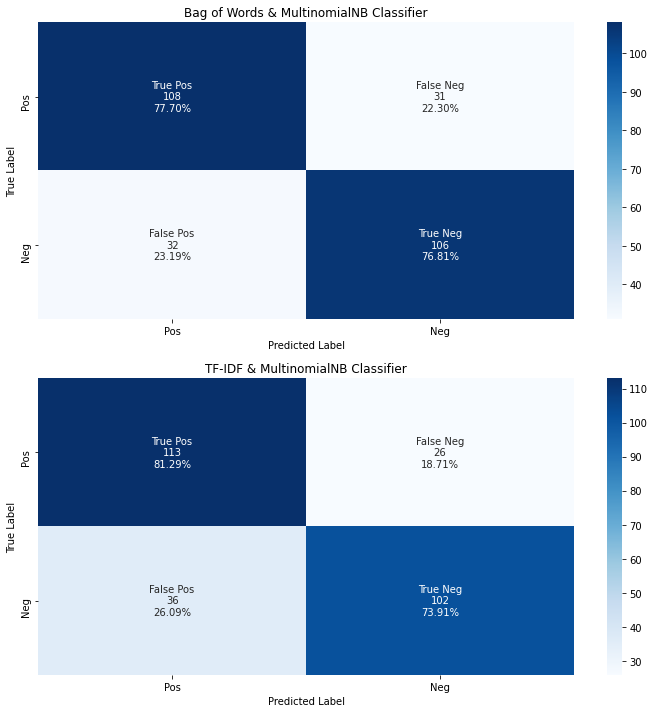

In [46]:
# Define multiple subplots
fig, axn = plt.subplots(2,figsize=(12,12))

# Re-create seaborn plots with new axes
tfidf_cms = sns.heatmap(tfidf_cm, annot=tf_labels,ax=axn[1], fmt='', cmap='Blues', xticklabels=['Pos','Neg'], yticklabels=['Pos','Neg'])
bowcms = sns.heatmap(bow_cm, annot=bow_labels,ax=axn[0], fmt='', cmap='Blues', xticklabels=['Pos','Neg'], yticklabels=['Pos','Neg'])

# Set labels
axn[0].set_title("Bag of Words & MultinomialNB Classifier")
axn[1].set_title("TF-IDF & MultinomialNB Classifier")
axn[0].set_xlabel("Predicted Label")
axn[1].set_xlabel("Predicted Label")
axn[0].set_ylabel("True Label")
axn[1].set_ylabel("True Label")

plt.show()

The first chart above shows the confusion matrix associated with the test predictions using the Bag of Words approach, and the second is the TF-IDF-based matrix. The percentages in each segment relate to the true label on the y-axis, for example in the BoW approach the 23.19% False Positive rate means that 23.19% of the rows with an original/true label of 'Neg' were given the prediction 'Pos'. Adding the percentage in the adjacent 'True Neg' box (i.e. 76.81%) equates to 100% i.e. the total of the 'Neg' true labels.

The true positives (TP), that is the rows that the model predicted 'Pos' and was correct, represents 78% of the 'Pos' true labels with the BoW model. The TF-IDF model shows an increase of 3% in it's TP rate. This coincides with a 3% decrease in the false negative rate, that is the rows the model predicted 'Neg' when it should have predicted 'Pos'.

So far it can be seen that the model has become better at predicting 'Pos' labels. However looking at how the new model determines a negative, it can be observed that performance has declined, as it's true negative rate  i.e. the instances where the model predicts 'Neg' and got it correct, has fallen from 77% to 74%.

From the above two charts, it is unclear whether an improvement has been attained by using the TF-IDF approach. To investigate further, the below cell shows the output of the `classification_report` from scikit-learn for the two methods:

In [47]:
print("BoW Prediction Report")
print(sklearn.metrics.classification_report(y_true=df_test['Sentiment'], y_pred=bow_prediction, labels=['Pos','Neg']))

print("\n\nTF-IDF Prediction Report")
print(sklearn.metrics.classification_report(y_true=df_test['Sentiment'], y_pred=tfidf_prediction, labels=['Pos','Neg']))

BoW Prediction Report
              precision    recall  f1-score   support

         Pos       0.77      0.78      0.77       139
         Neg       0.77      0.77      0.77       138

    accuracy                           0.77       277
   macro avg       0.77      0.77      0.77       277
weighted avg       0.77      0.77      0.77       277



TF-IDF Prediction Report
              precision    recall  f1-score   support

         Pos       0.76      0.81      0.78       139
         Neg       0.80      0.74      0.77       138

    accuracy                           0.78       277
   macro avg       0.78      0.78      0.78       277
weighted avg       0.78      0.78      0.78       277



<b>Precision</b> is defined as: $ TP / (TP + FP ) $ ,showing the proportion of the correct positive predictions to the total positive predictions. Intuitively this means "of all the rows the model predicted a particular class, how many did it get right?" ('positive' here doesn't necessarily mean the 'Pos' class; it is interchangeable for either label as shown in the table).

From the weighted average precision rate, the TF-IDF model performs 1% better than the BoW model, however this is a combination of an increase in performance of the 'Neg' class but a decrease in performance of the 'Pos' class.

<b>Recall</b> is defined as: $ TP / (TP + FN) $ ,showing the proportion of correct positives to the actual total positives. It gives an indication of coverage. Intuitively this describes "of all the actual 'Pos' classes, how many did the model capture?"

From the weighted average recall rate, again the TF-IDF model performed 1% better, but recall on the 'Pos' class has improved from 78% to 81% and on the 'Neg' class has declined from 77% to 74% between the two models.

Without having a specific preference for either precision or recall, it makes sense to observe the F1-score to determine the overall performance. The F1-score is a blended average of precision and recall, and overall this confirms that the TF-IDF approach performs marginally better (1%) than the Bag of Words approach. This is less than the Twitter analysis papers report of a 3-4% improvement, however given the previously outlined points about the size of the Twitter dataset, the number of classes and the more consistent length of the rows, this seems a reasonable result. 

## A further explanation for expected gains not realised

The below cells show a brief investigation into the false negative predictions that the model gave strong probabilities for, concluding with a hypothesis for why the anticipated gains from using a more sophisticated approach (TF-IDF) were not realised.

1. The probabilities of the predictions for each approach are merged along with the actual predictions to the original test dataset.


2. The resulting dataframe is then filtered to show 'Pos' true labels and 'Neg' predictions i.e. the false negatives.


3. The filtered dataframe is then sorted by the probability output of the tf-idf-based model, in order to find the predictions for which the model was incorrect, but was most confident about it being correct.

In [48]:
# Disable SettingWithCopyWarning occurring in the below lines
pd.options.mode.chained_assignment = None

# Obtain probabilities per prediction per class from both models
tf_pred_prob = mnb_tfidf.predict_proba(tfidf_test_vect)
bow_pred_prob = bow_mnb.predict_proba(bow_test_vect)

# Assign new columns detailing these probabilities
df_test['tf_prob_Neg'] = tf_pred_prob[:,0] 
df_test['tf_prob_Pos'] = tf_pred_prob[:,1]
df_test['bow_prob_Neg'] = bow_pred_prob[:,0] 
df_test['bow_prob_Pos'] = bow_pred_prob[:,1]

In [49]:
# Combine predictions with original test dataset + probabilities
results_df = pd.merge(left=df_test[['Review','Sentiment','bow_prob_Neg','tf_prob_Neg']].reset_index(drop=True), right=pd.DataFrame(tfidf_prediction, columns=['Prediction']), left_index=True, right_index=True)

In [50]:
# Filter results for false negatives only (true label = Pos & prediction = Neg)
false_negs = results_df[(results_df['Sentiment'] == 'Pos') & (results_df['Prediction'] == 'Neg' )]

In [51]:
# # Uncomment this cell to read the below reviews in full

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
# pd.set_option('display.max_colwidth', None)

In [52]:
# Sort results for the highest 'Neg' probabilities i.e. the worst predictions from the tf-idf model
false_negs.sort_values(by=['tf_prob_Neg'], ascending=False)[:5]

,Review,Sentiment,bow_prob_Neg,tf_prob_Neg,Prediction
97,In September I purchased my Ford Explorer Spo...,Pos,1.0,0.853547,Neg
61,Some of you might have read my previous post ...,Pos,1.0,0.805820,Neg
266,Ok I have reviewed the 97GT and the 89GT mus...,Pos,1.0,0.777126,Neg
131,I never even gave a thought to drive any sort...,Pos,1.0,0.734852,Neg
223,I have purchased an 1989 SHO sedan with 97k m...,Pos,1.0,0.694041,Neg


The above sample shows the 5 'worst' predictions, i.e. where the model gave a high probability of being 'Neg' but was technically incorrect. It should be noted that the reviews above are mainly negative as opposed to the given 'Pos' label, with some also being neutral. The extent to which this occurs throughout the dataset is unknown, however in comparing the probabilities given by the Bag of Words model (`bow_prob_neg`) and the tf-idf model (`tf_prob_neg`) it can be seen that both models strongly predict these reviews as being negative. The absence of a neutral class as well as these incorrectly labelled reviews may partially explain why the anticipated gains from using the tf-idf model were not realised, as the errors in the dataset could be severely hindering the performance of any model.

This is a significant issue and there is reasonable justification for a manual review of the dataset to either update the true labels, introduce a 'Neutral' class, or extend the dataset to reduce the impact of the erroneous rows.

### References

[1] Mccallum, Andrew & Nigam, Kamal. (2001). A Comparison of Event Models for Naive Bayes Text Classification. Work Learn Text Categ. 752. http://www.cs.cmu.edu/~knigam/papers/multinomial-aaaiws98.pdf

[2] Christopher D. Manning, Prabhakar Raghavan, Hinrich Schütze, "An Introduction to Information Retrieval", Cambridge University Press, 2009, https://nlp.stanford.edu/IR-book/html/htmledition/sublinear-tf-scaling-1.html

[3] Bruno Stecanella, "What is TF-IDF?", 2019, https://monkeylearn.com/blog/what-is-tf-idf/#:~:text=TF%2DIDF%20is%20a%20statistical,across%20a%20set%20of%20documents.

[4] Ravinder Ahuja, Aakarsha Chug, Shruti Kohli, Shaurya Gupta, Pratyush Ahuja,
"The Impact of Features Extraction on the Sentiment Analysis",
Procedia Computer Science,
Volume 152,
2019,
Pages 341-348,
ISSN 1877-0509,
(https://www.sciencedirect.com/science/article/pii/S1877050919306593)